# Text Classification using Naive Bayes

## Datasets
`Reuters-21578` datasets 사용

Reuters-21578 데이터는 22개 파일에 분산 돼 있고, `reut2-000.sgm`에서 `reut-021.sgm` 까지는 각각 1,000개의 doc을 갖고 있고, 마지막 `reut-022.sgm`은 578개의 doc을 갖고 있다.

`REUTER` tag 안에 있는 tag들

1. DATE
2. MKNOTE
3. **TOPICS**
4. PLACES
5. PEOPLE
6. ORGS
7. EXCHANGES
8. COMPANIES
9. UNKNOWN
10. **TEXT**


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import bs4
from collections import defaultdict, Counter
from functools import reduce
import nltk
import tqdm

In [2]:
base_dir = "reuters21578/"
all_exchanges = [_.strip() for _ in open(base_dir + "all-exchanges-strings.lc.txt", newline='\n').readlines()]
all_orgs = [_.strip() for _ in open(base_dir + "all-orgs-strings.lc.txt", newline="\n").readlines()]
all_people = [_.strip() for _ in open(base_dir + "all-people-strings.lc.txt", newline="\n").readlines()]
all_places = [_.strip() for _ in open(base_dir + "all-places-strings.lc.txt", newline="\n").readlines()]
all_topics = [_.strip() for _ in open(base_dir + "all-topics-strings.lc.txt", newline="\n").readlines()]

# print(all_exchanges)
# print("==")
# print(all_orgs)
# print("==")
# print(all_people)
# print("==")
# print(all_places)
# print("==")
# print(all_topics)

## Data Preprocessing
각각의 sgm 파일에서 documents들을 가져와, topic 별로 분류를 한다.

In [3]:
# Load all data and exclude reuters that have no topics
reuters = []

for i in range(22):
    file_name = base_dir + "reut2-{}.sgm".format(str(i).zfill(3))
    with open(file_name, "rt") as f:
        soup = bs4.BeautifulSoup(f.read(), "html5lib")
        tmp_reuters = soup.select("reuters")
        
        for r in tmp_reuters:
            if r.select("topics > d"):
                reuters.append(r)
print("All reuters count: ", len(reuters))

All reuters count:  11367


In [4]:
topics = defaultdict(list)
for i, _ in enumerate(reuters):
    t_l = _.select("topics > d")
    for t in t_l:
        topics[t.get_text()].append(i)

c:\users\yumere\appdata\local\programs\python\python35\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


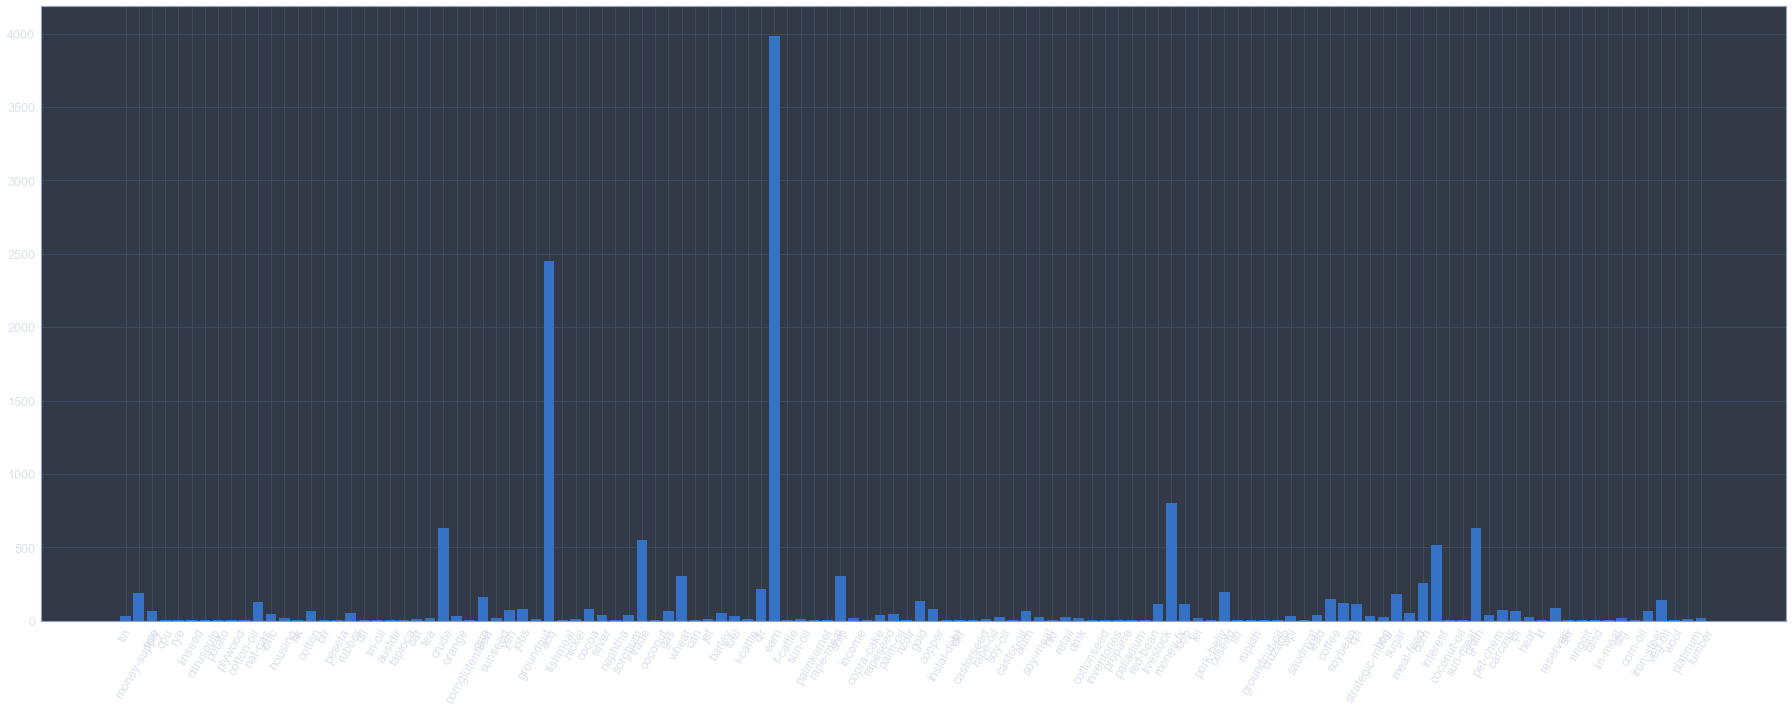

In [5]:
# Class 분류 안되는게 너무 많다. 10000개 이상
_x = [_ for _ in topics.keys() if _]
_y = [len(topics[_]) for _ in _x]

plt.figure(figsize=(25, 10))
plt.bar(list(range(len(_x))), _y, tick_label=_x)
plt.xticks(rotation=60)
plt.show()

## Calculate probability values according to Bayesian rule
`argmax(P(c_j | d))` 값을 구한다.

P(c | d) = { P(d | c) \* P(c) } / P(d)

P(d | c) = p(w_1 | c) \* P(w_2 | c) \* P(w_3 | c) \* ... \* P(w_i | c)

P(c_j) = count(d < c_j) / |D|
P(w_i | c_j) = count(w_i, c_j) / sum(count(w, c_j))

P(C)를 계산

전체 class `C`에서 해당 class `c_j`가 나올 확률

In [6]:
prob_c = defaultdict(float)
total_docs = 0
for t in topics.values():
    total_docs += len(t)

for k, v in topics.items():
    prob_c[k] = len(v) / total_docs

P(d | c_j)를 계산

해당 class에서 document `d`가 나올 확률
`d`가 나올 확률은 해당 class에서 `d` 안의 `w_i`들이 나올 확률의 곱

In [7]:
# 먼저 명사만 추출해 확률 값을 계산해 본다
all_w_c = defaultdict(int)
wc = defaultdict(Counter)

for t in topics:
    for d_index in topics[t]:
        d = reuters[d_index].select_one("text")
        words = [word for word, pos in nltk.pos_tag(nltk.word_tokenize(d.get_text())) if pos[:2] == "NN"]
        all_w_c[t] += len(words)
        wc[t].update(words)

In [8]:
V_size = len(set(reduce(lambda x,y: x+y, [list(v.keys()) for k, v in wc.items()])))
print("Vocabulary Size: ", V_size)

Vocabulary Size:  37563


## Test

In [9]:
print("All Test Size: ", len(reuters))
true_answer = 0
false_answer = 0

for i in tqdm.tqdm(reuters):
    r_topics = i.select("topics > d")
    topics_l = [_.get_text() for _ in r_topics]
    
    d = i.select_one("text").get_text()
    words = [word for word, pos in nltk.pos_tag(nltk.word_tokenize(d)) if pos[:2] == "NN"]
    
    acc = []
    for t in topics:
        pwc = 1.
        for word in words:
            pwc *= ((wc[t][word]+1) / (all_w_c[t] + V_size))
        acc.append((t, pwc * prob_c[t]))
    acc.sort(key=lambda x: x[1], reverse=True)

#     print("Topics: ", ", ".join(topics_l))
#     print("Predicted: ", ", ".join([_[0] for _ in acc[:10]]))
#     print()
    if acc[0][0] in topics_l:
        true_answer += 1
    else:
        false_answer += 1
        
print("True Answer: {}/{} ({} %)".format(true_answer, len(reuters), round(true_answer / len(reuters) * 100, 2)))
print("False Answer: {}/{} ({} %)".format(false_answer, len(reuters), round(false_answer / len(reuters) * 100, 2)))

All Test Size:  11367


100%|████████████████████████████████████████████████████████████████████████████| 11367/11367 [01:55<00:00, 75.92it/s]


True Answer: 8936/11367 (78.61 %)
False Answer: 2431/11367 (21.39 %)
